# Conditional Deep Convolutional Generative Adversarial Network (cDCGAN)
## Overview
This Notebook is a simple implementation of a Conditional Deep Convolutional Generative Adversarial Network (cDCGAN) using PyTorch on Shoe Dataset (Gray Scale) found on kaggle (https://www.kaggle.com/datasets/hasibalmuzdadid/shoe-vs-sandal-vs-boot-dataset-15k-images). The cDCGAN is a GAN that uses the label information to generate images of a specific class.

## Table of Contents
1. [Importing Libraries](#Imports)
2. [EDA](#EDA)
3. [Dataset and Dataloader](#Dataset_and_Dataloader)
4. [Model](#Model)
5. [Training](#Training)
6. [Results](#Results)

# Imports

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
import os
from torch.utils.data import DataLoader, Dataset, Subset, random_split
from torchvision import transforms, datasets
from torchvision.utils import make_grid
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
import random
from torchvision.utils import make_grid
from tqdm import tqdm
from scipy import linalg
from torch.nn.functional import adaptive_avg_pool2d
import torchvision.models as models
from IPython.display import clear_output

In [3]:
seed = 42
random.seed(seed)
torch.manual_seed(seed)

# EDA

In [4]:
DATA_DIR = "../Shoes-Dataset-Colored/"
BOOT_DIR = os.path.join(DATA_DIR, 'Boot')
SANDAL_DIR = os.path.join(DATA_DIR, 'Sandal')
SHOE_DIR = os.path.join(DATA_DIR, 'Shoe')

In [5]:
# image size
img = Image.open(os.path.join(BOOT_DIR, os.listdir(BOOT_DIR)[0]))
img = np.array(img)
img.shape


(102, 136, 3)

# Dataset and Dataloader

In [6]:
dir = "../Shoes-Dataset-Colored"
batch_size = 64

In [7]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.Grayscale(num_output_channels=3),  # Convert images to grayscale
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # Assuming grayscale, only one channel
])

footwear = datasets.ImageFolder(root=dir, transform=transform)
mapping = footwear.class_to_idx
mapping


{'Boot': 0, 'Sandal': 1, 'Shoe': 2}

In [8]:
footwear

Dataset ImageFolder
    Number of datapoints: 32222
    Root location: ../Shoes-Dataset-Colored
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
               Grayscale(num_output_channels=3)
               ToTensor()
               Normalize(mean=[0.5], std=[0.5])
           )

In [9]:
train_loader = DataLoader(footwear, batch_size=batch_size, shuffle=True, drop_last=True)

# Model

This model is Based on the Paper https://arxiv.org/pdf/1511.06434.pdf from this video: https://youtu.be/IZtv9s_Wx9I?si=Hw91zHv2KjFU-xel

Deconvolution Equation

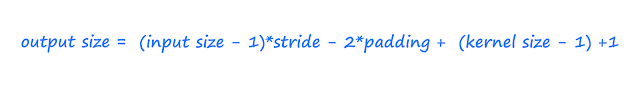

In [10]:
class Generator(nn.Module):
    def __init__(self, z_dim, channels_img, features_g,num_classes,img_size,embed_size):
        super(Generator, self).__init__()
        self.img_size = img_size
        self.generator = nn.Sequential(
            # Input: N x (z_dim * 2) x 1x1
            self._block(z_dim * 2, features_g * 32, 4, 1, 0),  # N x features_g * 32 x 4x4
            self._block(features_g * 32, features_g * 16, 4, 2, 1),  # N x features_g * 16 x 8x8
            self._block(features_g * 16, features_g * 8, 4, 2, 1),  # N x features_g * 8 x 16x16
            self._block(features_g * 8, features_g * 4, 4, 2, 1),  # N x features_g * 4 x 32x32
            self._block(features_g * 4, features_g * 2, 4, 2, 1),  # N x features_g * 2 x 64x64
            nn.ConvTranspose2d(features_g * 2, channels_img, kernel_size=4, stride=2, padding=1),  # N x channels_img x 128x128
            nn.Tanh()  # [-1, 1]
        )
        self.embed = nn.Embedding(num_classes, embed_size)
    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels, 
                out_channels, 
                kernel_size, 
                stride, 
                padding,
                bias=False
            ), # deconvolution
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
    def forward(self, x, labels):
        # latent vector z: N x z_dim x 1 x 1
        embedding = self.embed(labels).unsqueeze(2).unsqueeze(3)
        x = torch.cat([x, embedding], dim=1)
        return self.generator(x)

Convolution Equation:


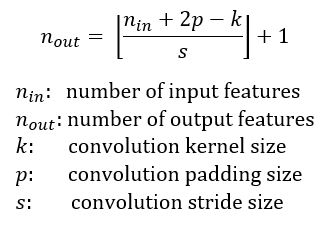

In [11]:
class Discriminator(nn.Module):   
    def __init__(self, channel_imgs, features_d,num_classes, img_size):
        super(Discriminator, self).__init__()
        self.img_size = img_size
        # Input shape will be N(batch_size) x channel_imgs(1) x 64 x 64
        self.discriminator = nn.Sequential(
            nn.Conv2d(channel_imgs + 1, features_d, kernel_size=4, stride=2, padding=1),  # 64 x 64
            nn.LeakyReLU(0.2),
            self._block(features_d, features_d * 2, 4, 2, 1),  # 32 x 32
            self._block(features_d * 2, features_d * 4, 4, 2, 1),  # 16 x 16
            self._block(features_d * 4, features_d * 8, 4, 2, 1),  # 8 x 8
            nn.Conv2d(features_d * 8, out_channels=1, kernel_size=8, stride=2, padding=0),  # 1 x 1
            nn.Sigmoid()
        )
        self.embed = nn.Embedding(num_classes, img_size*img_size)
    
    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels, 
                kernel_size,
                stride,
                padding,
                bias=False
            ),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2)
        )
        
    def forward(self, x, labels):
        embedding = self.embed(labels).view(labels.shape[0], 1, self.img_size, self.img_size)
        x = torch.cat([x, embedding], dim=1) # N x C x H x W
        return self.discriminator(x)

In [12]:
def intialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

In [13]:
def test():
    N, in_channels, H, W = 32, 3, 128, 128
    num_classes = 3
    label = torch.randint(0, num_classes, (N,))
    z_dim = 100
    x = torch.randn((N, in_channels, H, W))
    disc = Discriminator(in_channels, 8, num_classes, H)
    intialize_weights(disc)
    assert disc(x,label).shape == (N, 1, 1, 1), "Discriminator test failed"
    gen = Generator(z_dim, in_channels, 8, num_classes, H, 100)
    intialize_weights(gen)
    z = torch.randn((N, z_dim, 1, 1))
    assert gen(z,label).shape == (N, in_channels, H, W), "Generator test failed"
    print("All tests passed")
test()

All tests passed


# Training

In [14]:
# Set the device (CPU or GPU)
if torch.cuda.is_available():
    print("Using GPU")
else:
    print("Using CPU")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Using GPU


In [15]:
# Define the hyperparameters
lr = 2e-4
batch_size = 64
image_size = 128
in_channels = 3
z_dim = 100
epochs = 500
features_disc = 64
features_gen = 64
num_classes = 3
gen_embed_size = 100

In [16]:
gen = Generator(z_dim, in_channels, features_gen,num_classes,image_size,gen_embed_size).to(device)
disc = Discriminator(in_channels, features_disc,num_classes,image_size ).to(device)
intialize_weights(gen)
intialize_weights(disc)
opt_gen = optim.Adam(gen.parameters(), lr=lr, betas=(0.5, 0.999))
opt_disc = optim.Adam(disc.parameters(), lr=lr, betas=(0.5, 0.999))
criterion = nn.BCELoss()

In [17]:
fixed_noise = torch.randn(32, z_dim, 1, 1).to(device)
writer_real = SummaryWriter(f"logs/real")
write_fake = SummaryWriter(f"logs/fake")
step = 0

In [18]:
gen.train()

Generator(
  (generator): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(200, 2048, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): ConvTranspose2d(2048, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (2): Sequential(
      (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (3): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (4): Sequential(
   

In [19]:
disc.train()

Discriminator(
  (discriminator): Sequential(
    (0): Conv2d(4, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (4): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (5): Conv2d(512, 1, kernel_size=(8, 8), stride=(2, 2))
    (6): Sigmoid()
  )
  (embe

## FID Metric

In [20]:
class InceptionV3(nn.Module):
    """Pretrained InceptionV3 network returning feature maps"""

    # Index of default block of inception to return,
    # corresponds to output of final average pooling
    DEFAULT_BLOCK_INDEX = 3

    # Maps feature dimensionality to their output blocks indices
    BLOCK_INDEX_BY_DIM = {
        64: 0,   # First max pooling features
        192: 1,  # Second max pooling featurs
        768: 2,  # Pre-aux classifier features
        2048: 3  # Final average pooling features
    }

    def __init__(self,
                 output_blocks=[DEFAULT_BLOCK_INDEX],
                 resize_input=True,
                 normalize_input=True,
                 requires_grad=False):
        
        super(InceptionV3, self).__init__()

        self.resize_input = resize_input
        self.normalize_input = normalize_input
        self.output_blocks = sorted(output_blocks)
        self.last_needed_block = max(output_blocks)

        assert self.last_needed_block <= 3, \
            'Last possible output block index is 3'

        self.blocks = nn.ModuleList()

        
        inception = models.inception_v3(pretrained=True)

        # Block 0: input to maxpool1
        block0 = [
            inception.Conv2d_1a_3x3,
            inception.Conv2d_2a_3x3,
            inception.Conv2d_2b_3x3,
            nn.MaxPool2d(kernel_size=3, stride=2)
        ]
        self.blocks.append(nn.Sequential(*block0))

        # Block 1: maxpool1 to maxpool2
        if self.last_needed_block >= 1:
            block1 = [
                inception.Conv2d_3b_1x1,
                inception.Conv2d_4a_3x3,
                nn.MaxPool2d(kernel_size=3, stride=2)
            ]
            self.blocks.append(nn.Sequential(*block1))

        # Block 2: maxpool2 to aux classifier
        if self.last_needed_block >= 2:
            block2 = [
                inception.Mixed_5b,
                inception.Mixed_5c,
                inception.Mixed_5d,
                inception.Mixed_6a,
                inception.Mixed_6b,
                inception.Mixed_6c,
                inception.Mixed_6d,
                inception.Mixed_6e,
            ]
            self.blocks.append(nn.Sequential(*block2))

        # Block 3: aux classifier to final avgpool
        if self.last_needed_block >= 3:
            block3 = [
                inception.Mixed_7a,
                inception.Mixed_7b,
                inception.Mixed_7c,
                nn.AdaptiveAvgPool2d(output_size=(1, 1))
            ]
            self.blocks.append(nn.Sequential(*block3))

        for param in self.parameters():
            param.requires_grad = requires_grad

    def forward(self, inp):
        """Get Inception feature maps
        Parameters
        ----------
        inp : torch.autograd.Variable
            Input tensor of shape Bx3xHxW. Values are expected to be in
            range (0, 1)
        Returns
        -------
        List of torch.autograd.Variable, corresponding to the selected output
        block, sorted ascending by index
        """
        outp = []
        x = inp

        if self.resize_input:
            x = F.interpolate(x,
                              size=(299, 299),
                              mode='bilinear',
                              align_corners=False)

        if self.normalize_input:
            x = 2 * x - 1  # Scale from range (0, 1) to range (-1, 1)

        for idx, block in enumerate(self.blocks):
            x = block(x)
            if idx in self.output_blocks:
                outp.append(x)

            if idx == self.last_needed_block:
                break

        return outp
    
block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[2048]
model = InceptionV3([block_idx])
model=model.cuda()

c:\Users\ahksa.LAPTOP-394KBUA4\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ahksa.LAPTOP-394KBUA4\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [21]:
def calculate_activation_statistics(images,model,batch_size=32, dims=2048,
                    cuda=False):
    model.eval()
    act=np.empty((len(images), dims))
    
    if cuda:
        batch=images.cuda()
    else:
        batch=images
    pred = model(batch)[0]

        # If model output is not scalar, apply global spatial average pooling.
        # This happens if you choose a dimensionality not equal 2048.
    if pred.size(2) != 1 or pred.size(3) != 1:
        pred = adaptive_avg_pool2d(pred, output_size=(1, 1))

    act= pred.cpu().data.numpy().reshape(pred.size(0), -1)
    
    mu = np.mean(act, axis=0)
    sigma = np.cov(act, rowvar=False)
    return mu, sigma

In [22]:
def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    """Numpy implementation of the Frechet Distance.
    The Frechet distance between two multivariate Gaussians X_1 ~ N(mu_1, C_1)
    and X_2 ~ N(mu_2, C_2) is
            d^2 = ||mu_1 - mu_2||^2 + Tr(C_1 + C_2 - 2*sqrt(C_1*C_2)).
    """

    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, \
        'Training and test mean vectors have different lengths'
    assert sigma1.shape == sigma2.shape, \
        'Training and test covariances have different dimensions'

    diff = mu1 - mu2

    
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = ('fid calculation produces singular product; '
               'adding %s to diagonal of cov estimates') % eps
        print(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError('Imaginary component {}'.format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return (diff.dot(diff) + np.trace(sigma1) +
            np.trace(sigma2) - 2 * tr_covmean)

In [23]:
def calculate_fretchet(images_real,images_fake,model):
     mu_1,std_1=calculate_activation_statistics(images_real,model,cuda=True)
     mu_2,std_2=calculate_activation_statistics(images_fake,model,cuda=True)
    
     """get fretched distance"""
     fid_value = calculate_frechet_distance(mu_1, std_1, mu_2, std_2)
     return fid_value

## Training Loop

In [24]:
losses_disc = []
losses_gen = []
fid_scores = []

In [24]:
# gen.load_state_dict(torch.load("./cDCGANs-Gray/cDCGANs-Gray-Arch-2-/gen_.pth"))
# disc.load_state_dict(torch.load("./cDCGANs-Gray/cDCGANs-Gray-Arch-2-/disc_.pth"))
# opt_disc.load_state_dict(torch.load("./cDCGANs-Gray/cDCGANs-Gray-Arch-2-/opt_disc_.pth"))
# opt_gen.load_state_dict(torch.load("./cDCGANs-Gray/cDCGANs-Gray-Arch-2-/opt_gen_.pth"))
# loss_disc = torch.load("./cDCGANs-Gray/cDCGANs-Gray-Arch-2-/losses_disc.pth")
# loss_gen = torch.load("./cDCGANs-Gray/cDCGANs-Gray-Arch-2-/losses_gen.pth")
# fid_scores_prev = torch.load("./cDCGANs-Gray/cDCGANs-Gray-Arch-2-/fid_scores.pth")

In [25]:
start_epoch = 0
step = 0
# losses_disc = loss_disc
# losses_gen = loss_gen
# fid_scores = fid_scores_prev

for epoch in range(start_epoch, epochs):
    tqdm_train_loader = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
    for batch_idx, (real, labels) in enumerate(tqdm_train_loader):
        real = real.to(device)
        noise = torch.randn(batch_size, z_dim, 1, 1).to(device)
        labels = labels.to(device)
        fake = gen(noise,labels)
        
        # Train Discriminator: max log(D(real)) + log(1 - D(G(z)))
        disc_real = disc(real,labels).reshape(-1)
        loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))
        disc_fake = disc(fake,labels).reshape(-1)
        loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        loss_disc = (loss_disc_real + loss_disc_fake)/2
        disc.zero_grad()
        loss_disc.backward(retain_graph=True)
        opt_disc.step()
            
        
        ## Train Generator: min -E[disc(gen_fake)]
        output = disc(fake, labels).reshape(-1)
        loss_gen = -torch.mean(output)
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()
        losses_gen.append(loss_gen.item())
        losses_disc.append(loss_disc.item())
        # Update progress bar description
        tqdm_train_loader.set_postfix({"Loss D": loss_disc.item(), "Loss G": loss_gen.item()})

        if batch_idx % 100 == 0:
            tqdm_train_loader.write(
                f"Epoch [{epoch+1}/{epochs}] Batch {batch_idx}/{len(train_loader)} Loss D: {loss_disc:.4f}, loss G: {loss_gen:.4f}"
            )

            with torch.no_grad():
                fake = gen(noise, labels)
                img_grid_real = make_grid(real[:32], normalize=True)
                img_grid_fake = make_grid(fake[:32], normalize=True)
                writer_real.add_image("Real", img_grid_real, global_step=step)
                write_fake.add_image("Fake", img_grid_fake, global_step=step)
                step += 1

    # Visualize and print losses after each epoch
    plt.figure(figsize=(10, 5))
    plt.plot(losses_disc, label='Disc Loss')
    plt.plot(losses_gen, label='Generator Loss')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title(f'Epoch {epoch+1}/{epochs}: Disc and Generator Losses')
    plt.legend()
    os.makedirs("cDCGANs-Gray/images/loss", exist_ok=True)
    plt.savefig(f"cDCGANs-Gray/images/loss/loss{epoch+1}.png")
    plt.close()
    # Calculate and visualize FID every epoch
    with torch.no_grad():
        fake = gen(noise, labels)
        fid = calculate_fretchet(real, fake, model)
        fid_scores.append(fid)

        # Visualize FID
        plt.figure(figsize=(10, 5))
        plt.plot(range(epoch + 1), fid_scores, label='FID')
        plt.xlabel('Epoch')
        plt.ylabel('FID')
        plt.title('FID Score')
        plt.legend()
        os.makedirs("cDCGANs-Gray/images/fid", exist_ok=True)
        plt.savefig(f"cDCGANs-Gray/images/fid/fid{epoch+1}.png")
        plt.close()

        # Print FID score
        print(f"Epoch [{epoch+1}/{epochs}] FID: {fid:.4f}")

    if (epoch+1) % 1 == 0 or epoch == 0:
        gen.eval()
        noise = torch.randn(32, z_dim, 1, 1).to(device)
        fake = gen(noise, labels[:32])
        img_grid_fake = make_grid(fake[:32], normalize=True)
        plt.imshow(img_grid_fake.permute(1, 2, 0).cpu().numpy())
        os.makedirs("cDCGANs-Gray/images/fake", exist_ok=True)
        plt.savefig(f"cDCGANs-Gray/images/fake/fake{epoch+1}.png")
        plt.close()

    # Save evaluation metrics, generator, disc, and optimizers every 50 epochs
    if (epoch + 1) % 50 == 0:
        os.makedirs(f"cDCGANs-Gray/cDCGANs-Gray-Arch-2-{epoch+1}", exist_ok=True)
        
        # Visualize FID
        plt.figure(figsize=(10, 5))
        plt.plot(range(epoch + 1), fid_scores, label='FID')
        plt.xlabel('Epoch')
        plt.ylabel('FID')
        plt.title('FID Score')
        plt.legend()
        plt.savefig(f"cDCGANs-Gray/cDCGANs-Gray-Arch-2-{epoch+1}/fid_plot.png")
        plt.close()
        
        plt.figure(figsize=(10, 5))
        plt.plot(losses_disc, label='Disc Loss')
        plt.plot(losses_gen, label='Generator Loss')
        plt.xlabel('Iteration')
        plt.ylabel('Loss')
        plt.title(f'Epoch {epoch+1}/{epochs}: Disc and Generator Losses')
        plt.legend()
        plt.savefig(f"cDCGANs-Gray/cDCGANs-Gray-Arch-2-{epoch+1}/losses_plot.png")  
        
        plt.imsave(f"cDCGANs-Gray/cDCGANs-Gray-Arch-2-{epoch+1}/fake_{epoch+1}.png", img_grid_fake.permute(1, 2, 0).cpu().numpy())
        # Save evaluation metrics
        evaluation_metrics = {"FID": fid_scores[-1]}
        torch.save(evaluation_metrics, f"cDCGANs-Gray/cDCGANs-Gray-Arch-2-{epoch+1}/evaluation_metrics.pth")

        # Save generator, disc, and optimizers
        torch.save(gen.state_dict(), f"cDCGANs-Gray/cDCGANs-Gray-Arch-2-{epoch+1}/gen_{epoch+1}.pth")
        torch.save(disc.state_dict(), f"cDCGANs-Gray/cDCGANs-Gray-Arch-2-{epoch+1}/disc_{epoch+1}.pth")
        torch.save(opt_gen.state_dict(), f"cDCGANs-Gray/cDCGANs-Gray-Arch-2-{epoch+1}/opt_gen_{epoch+1}.pth")
        torch.save(opt_disc.state_dict(), f"cDCGANs-Gray/cDCGANs-Gray-Arch-2-{epoch+1}/opt_disc_{epoch+1}.pth")

        # Save losses and evaluation scores to files
        torch.save(losses_disc, f"cDCGANs-Gray/cDCGANs-Gray-Arch-2-{epoch+1}/losses_disc.pth")
        torch.save(losses_gen, f"cDCGANs-Gray/cDCGANs-Gray-Arch-2-{epoch+1}/losses_gen.pth")
        torch.save(fid_scores, f"cDCGANs-Gray/cDCGANs-Gray-Arch-2-{epoch+1}/fid_scores.pth")
    if (epoch+1) %25 == 0:
        clear_output()
    gen.train()


Epoch 351/500:   0%|          | 0/503 [00:00<?, ?it/s, Loss D=2.58e-6, Loss G=-2.21e-6]

Epoch [351/500] Batch 0/503 Loss D: 0.0000, loss G: -0.0000


Epoch 351/500:  20%|█▉        | 100/503 [00:55<03:39,  1.83it/s, Loss D=5.41e-5, Loss G=-3.84e-6]

Epoch [351/500] Batch 100/503 Loss D: 0.0001, loss G: -0.0000


Epoch 351/500:  40%|███▉      | 200/503 [01:50<02:45,  1.83it/s, Loss D=4.76e-5, Loss G=-6.79e-6] 

Epoch [351/500] Batch 200/503 Loss D: 0.0000, loss G: -0.0000


Epoch 351/500:  60%|█████▉    | 300/503 [02:45<01:49,  1.85it/s, Loss D=1.09e-5, Loss G=-1.14e-5] 

Epoch [351/500] Batch 300/503 Loss D: 0.0000, loss G: -0.0000


Epoch 351/500:  80%|███████▉  | 400/503 [03:39<00:55,  1.84it/s, Loss D=6.86e-6, Loss G=-7.82e-6] 

Epoch [351/500] Batch 400/503 Loss D: 0.0000, loss G: -0.0000


Epoch 351/500:  99%|█████████▉| 500/503 [04:34<00:01,  1.84it/s, Loss D=4.66e-5, Loss G=-1.9e-5]  

Epoch [351/500] Batch 500/503 Loss D: 0.0000, loss G: -0.0000


Epoch 351/500: 100%|██████████| 503/503 [04:36<00:00,  1.82it/s, Loss D=4.82e-6, Loss G=-7.61e-6]


Epoch [351/500] FID: 278.4680


Epoch 352/500:   0%|          | 0/503 [00:00<?, ?it/s, Loss D=1.26e-5, Loss G=-1.31e-5]

Epoch [352/500] Batch 0/503 Loss D: 0.0000, loss G: -0.0000


Epoch 352/500:  20%|█▉        | 100/503 [00:55<03:38,  1.85it/s, Loss D=7.87e-6, Loss G=-9.66e-6]

Epoch [352/500] Batch 100/503 Loss D: 0.0000, loss G: -0.0000


Epoch 352/500:  40%|███▉      | 200/503 [01:50<02:50,  1.78it/s, Loss D=0.00055, Loss G=-0.000736] 

Epoch [352/500] Batch 200/503 Loss D: 0.0005, loss G: -0.0007


Epoch 352/500:  43%|████▎     | 218/503 [02:00<02:41,  1.76it/s, Loss D=0.0006, Loss G=-0.00095]   

In [25]:
gen.load_state_dict(torch.load("C:\\Users\\ahksa.LAPTOP-394KBUA4\\OneDrive\\Desktop\\CESS Files\\Semester 6\\Artificial Intelligence\\Project\\Image-Generation-Using-Generative-AI\\cDCGANs-Gray-Scaled\\cDCGANs-Gray\\cDCGANs-Gray-Arch-2-350\\gen_350.pth"))
disc.load_state_dict(torch.load("C:\\Users\\ahksa.LAPTOP-394KBUA4\\OneDrive\\Desktop\\CESS Files\\Semester 6\\Artificial Intelligence\\Project\\Image-Generation-Using-Generative-AI\\cDCGANs-Gray-Scaled\\cDCGANs-Gray\\cDCGANs-Gray-Arch-2-350\\disc_350.pth"))
opt_disc.load_state_dict(torch.load("C:\\Users\\ahksa.LAPTOP-394KBUA4\\OneDrive\\Desktop\\CESS Files\\Semester 6\\Artificial Intelligence\\Project\\Image-Generation-Using-Generative-AI\\cDCGANs-Gray-Scaled\\cDCGANs-Gray\\cDCGANs-Gray-Arch-2-350\\opt_disc_350.pth"))
opt_gen.load_state_dict(torch.load("C:\\Users\\ahksa.LAPTOP-394KBUA4\\OneDrive\\Desktop\\CESS Files\\Semester 6\\Artificial Intelligence\\Project\\Image-Generation-Using-Generative-AI\\cDCGANs-Gray-Scaled\\cDCGANs-Gray\\cDCGANs-Gray-Arch-2-350\\opt_gen_350.pth"))
loss_disc = torch.load("C:\\Users\\ahksa.LAPTOP-394KBUA4\\OneDrive\\Desktop\\CESS Files\\Semester 6\\Artificial Intelligence\\Project\\Image-Generation-Using-Generative-AI\\cDCGANs-Gray-Scaled\\cDCGANs-Gray\\cDCGANs-Gray-Arch-2-350\\losses_disc.pth")
loss_gen = torch.load("C:\\Users\\ahksa.LAPTOP-394KBUA4\\OneDrive\\Desktop\\CESS Files\\Semester 6\\Artificial Intelligence\\Project\\Image-Generation-Using-Generative-AI\\cDCGANs-Gray-Scaled\\cDCGANs-Gray\\cDCGANs-Gray-Arch-2-350\\losses_gen.pth")
fid_scores_prev = torch.load("C:\\Users\\ahksa.LAPTOP-394KBUA4\\OneDrive\\Desktop\\CESS Files\\Semester 6\\Artificial Intelligence\\Project\\Image-Generation-Using-Generative-AI\\cDCGANs-Gray-Scaled\\cDCGANs-Gray\\cDCGANs-Gray-Arch-2-350\\fid_scores.pth")

In [26]:
start_epoch = 350
step = 0
losses_disc = loss_disc
losses_gen = loss_gen
fid_scores = fid_scores_prev

for epoch in range(start_epoch, epochs):
    tqdm_train_loader = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
    for batch_idx, (real, labels) in enumerate(tqdm_train_loader):
        real = real.to(device)
        noise = torch.randn(batch_size, z_dim, 1, 1).to(device)
        labels = labels.to(device)
        fake = gen(noise,labels)
        
        # Train Discriminator: max log(D(real)) + log(1 - D(G(z)))
        disc_real = disc(real,labels).reshape(-1)
        loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))
        disc_fake = disc(fake,labels).reshape(-1)
        loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        loss_disc = (loss_disc_real + loss_disc_fake)/2
        disc.zero_grad()
        loss_disc.backward(retain_graph=True)
        opt_disc.step()
            
        
        ## Train Generator: min -E[disc(gen_fake)]
        output = disc(fake, labels).reshape(-1)
        loss_gen = -torch.mean(output)
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()
        losses_gen.append(loss_gen.item())
        losses_disc.append(loss_disc.item())
        # Update progress bar description
        tqdm_train_loader.set_postfix({"Loss D": loss_disc.item(), "Loss G": loss_gen.item()})

        if batch_idx % 100 == 0:
            tqdm_train_loader.write(
                f"Epoch [{epoch+1}/{epochs}] Batch {batch_idx}/{len(train_loader)} Loss D: {loss_disc:.4f}, loss G: {loss_gen:.4f}"
            )

            with torch.no_grad():
                fake = gen(noise, labels)
                img_grid_real = make_grid(real[:32], normalize=True)
                img_grid_fake = make_grid(fake[:32], normalize=True)
                writer_real.add_image("Real", img_grid_real, global_step=step)
                write_fake.add_image("Fake", img_grid_fake, global_step=step)
                step += 1

    # Visualize and print losses after each epoch
    plt.figure(figsize=(10, 5))
    plt.plot(losses_disc, label='Disc Loss')
    plt.plot(losses_gen, label='Generator Loss')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title(f'Epoch {epoch+1}/{epochs}: Disc and Generator Losses')
    plt.legend()
    os.makedirs("cDCGANs-Gray/images/loss", exist_ok=True)
    plt.savefig(f"cDCGANs-Gray/images/loss/loss{epoch+1}.png")
    plt.close()
    # Calculate and visualize FID every epoch
    with torch.no_grad():
        fake = gen(noise, labels)
        fid = calculate_fretchet(real, fake, model)
        fid_scores.append(fid)

        # Visualize FID
        plt.figure(figsize=(10, 5))
        plt.plot(range(epoch + 1), fid_scores, label='FID')
        plt.xlabel('Epoch')
        plt.ylabel('FID')
        plt.title('FID Score')
        plt.legend()
        os.makedirs("cDCGANs-Gray/images/fid", exist_ok=True)
        plt.savefig(f"cDCGANs-Gray/images/fid/fid{epoch+1}.png")
        plt.close()

        # Print FID score
        print(f"Epoch [{epoch+1}/{epochs}] FID: {fid:.4f}")

    if (epoch+1) % 1 == 0 or epoch == 0:
        gen.eval()
        noise = torch.randn(32, z_dim, 1, 1).to(device)
        fake = gen(noise, labels[:32])
        img_grid_fake = make_grid(fake[:32], normalize=True)
        plt.imshow(img_grid_fake.permute(1, 2, 0).cpu().numpy())
        os.makedirs("cDCGANs-Gray/images/fake", exist_ok=True)
        plt.savefig(f"cDCGANs-Gray/images/fake/fake{epoch+1}.png")
        plt.close()

    # Save evaluation metrics, generator, disc, and optimizers every 50 epochs
    if (epoch + 1) % 50 == 0:
        os.makedirs(f"cDCGANs-Gray/cDCGANs-Gray-Arch-2-{epoch+1}", exist_ok=True)
        
        # Visualize FID
        plt.figure(figsize=(10, 5))
        plt.plot(range(epoch + 1), fid_scores, label='FID')
        plt.xlabel('Epoch')
        plt.ylabel('FID')
        plt.title('FID Score')
        plt.legend()
        plt.savefig(f"cDCGANs-Gray/cDCGANs-Gray-Arch-2-{epoch+1}/fid_plot.png")
        plt.close()
        
        plt.figure(figsize=(10, 5))
        plt.plot(losses_disc, label='Disc Loss')
        plt.plot(losses_gen, label='Generator Loss')
        plt.xlabel('Iteration')
        plt.ylabel('Loss')
        plt.title(f'Epoch {epoch+1}/{epochs}: Disc and Generator Losses')
        plt.legend()
        plt.savefig(f"cDCGANs-Gray/cDCGANs-Gray-Arch-2-{epoch+1}/losses_plot.png")  
        
        plt.imsave(f"cDCGANs-Gray/cDCGANs-Gray-Arch-2-{epoch+1}/fake_{epoch+1}.png", img_grid_fake.permute(1, 2, 0).cpu().numpy())
        # Save evaluation metrics
        evaluation_metrics = {"FID": fid_scores[-1]}
        torch.save(evaluation_metrics, f"cDCGANs-Gray/cDCGANs-Gray-Arch-2-{epoch+1}/evaluation_metrics.pth")

        # Save generator, disc, and optimizers
        torch.save(gen.state_dict(), f"cDCGANs-Gray/cDCGANs-Gray-Arch-2-{epoch+1}/gen_{epoch+1}.pth")
        torch.save(disc.state_dict(), f"cDCGANs-Gray/cDCGANs-Gray-Arch-2-{epoch+1}/disc_{epoch+1}.pth")
        torch.save(opt_gen.state_dict(), f"cDCGANs-Gray/cDCGANs-Gray-Arch-2-{epoch+1}/opt_gen_{epoch+1}.pth")
        torch.save(opt_disc.state_dict(), f"cDCGANs-Gray/cDCGANs-Gray-Arch-2-{epoch+1}/opt_disc_{epoch+1}.pth")

        # Save losses and evaluation scores to files
        torch.save(losses_disc, f"cDCGANs-Gray/cDCGANs-Gray-Arch-2-{epoch+1}/losses_disc.pth")
        torch.save(losses_gen, f"cDCGANs-Gray/cDCGANs-Gray-Arch-2-{epoch+1}/losses_gen.pth")
        torch.save(fid_scores, f"cDCGANs-Gray/cDCGANs-Gray-Arch-2-{epoch+1}/fid_scores.pth")
    if (epoch+1) %25 == 0:
        clear_output()
    gen.train()


Epoch 451/500:   0%|          | 0/503 [00:01<?, ?it/s, Loss D=0.00139, Loss G=-0.00128]

Epoch [451/500] Batch 0/503 Loss D: 0.0014, loss G: -0.0013


Epoch 451/500:  20%|█▉        | 100/503 [01:54<07:29,  1.12s/it, Loss D=0.00433, Loss G=-0.00283] 

Epoch [451/500] Batch 100/503 Loss D: 0.0043, loss G: -0.0028


Epoch 451/500:  40%|███▉      | 200/503 [03:48<05:56,  1.18s/it, Loss D=0.00335, Loss G=-0.00334]  

Epoch [451/500] Batch 200/503 Loss D: 0.0034, loss G: -0.0033


Epoch 451/500:  60%|█████▉    | 300/503 [05:38<03:30,  1.04s/it, Loss D=0.00167, Loss G=-0.000716] 

Epoch [451/500] Batch 300/503 Loss D: 0.0017, loss G: -0.0007


Epoch 451/500:  80%|███████▉  | 400/503 [07:29<02:30,  1.46s/it, Loss D=3.44e-5, Loss G=-1.9e-5]  

Epoch [451/500] Batch 400/503 Loss D: 0.0000, loss G: -0.0000


Epoch 451/500:  99%|█████████▉| 500/503 [16:04<00:10,  3.56s/it, Loss D=1.39e-5, Loss G=-1.05e-9]  

Epoch [451/500] Batch 500/503 Loss D: 0.0000, loss G: -0.0000


Epoch 451/500: 100%|██████████| 503/503 [16:12<00:00,  1.93s/it, Loss D=2.44e-5, Loss G=-1.4e-9]  


Epoch [451/500] FID: 275.2848


Epoch 452/500:   0%|          | 0/503 [00:03<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
os.makedirs(f"cDCGANs-Gray/cDCGANs-Gray-Arch-2-{epoch+1}", exist_ok=True)
        
# Visualize FID
plt.figure(figsize=(10, 5))
plt.plot(range(epoch + 1), fid_scores, label='FID')
plt.xlabel('Epoch')
plt.ylabel('FID')
plt.title('FID Score')
plt.legend()
plt.savefig(f"cDCGANs-Gray/cDCGANs-Gray-Arch-2-{epoch+1}/fid_plot.png")
plt.close()

plt.figure(figsize=(10, 5))
plt.plot(losses_disc, label='Disc Loss')
plt.plot(losses_gen, label='Generator Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title(f'Epoch {epoch+1}/{epochs}: Disc and Generator Losses')
plt.legend()
plt.savefig(f"cDCGANs-Gray/cDCGANs-Gray-Arch-2-{epoch+1}/losses_plot.png")  

plt.imsave(f"cDCGANs-Gray/cDCGANs-Gray-Arch-2-{epoch+1}/fake_{epoch+1}.png", img_grid_fake.permute(1, 2, 0).cpu().numpy())
# Save evaluation metrics
evaluation_metrics = {"FID": fid_scores[-1]}
torch.save(evaluation_metrics, f"cDCGANs-Gray/cDCGANs-Gray-Arch-2-{epoch+1}/evaluation_metrics.pth")

# Save generator, disc, and optimizers
torch.save(gen.state_dict(), f"cDCGANs-Gray/cDCGANs-Gray-Arch-2-{epoch+1}/gen_{epoch+1}.pth")
torch.save(disc.state_dict(), f"cDCGANs-Gray/cDCGANs-Gray-Arch-2-{epoch+1}/disc_{epoch+1}.pth")
torch.save(opt_gen.state_dict(), f"cDCGANs-Gray/cDCGANs-Gray-Arch-2-{epoch+1}/opt_gen_{epoch+1}.pth")
torch.save(opt_disc.state_dict(), f"cDCGANs-Gray/cDCGANs-Gray-Arch-2-{epoch+1}/opt_disc_{epoch+1}.pth")

# Save losses and evaluation scores to files
torch.save(losses_disc, f"cDCGANs-Gray/cDCGANs-Gray-Arch-2-{epoch+1}/losses_disc.pth")
torch.save(losses_gen, f"cDCGANs-Gray/cDCGANs-Gray-Arch-2-{epoch+1}/losses_gen.pth")
torch.save(fid_scores, f"cDCGANs-Gray/cDCGANs-Gray-Arch-2-{epoch+1}/fid_scores.pth")

# Results

In [ ]:
torch.cuda.empty_cache()

In [ ]:
# Load the model
gen_loaded = Generator(z_dim=100, channels_img=1, features_g=64, num_classes=3, img_size=64, embed_size=100)
gen_loaded.load_state_dict(torch.load("cDCGANs-Gray-Arch-2-41/gen_41.pth"))
gen_loaded.eval()


labels = torch.LongTensor([random.randint(0,2) for i in range(32)])
noise = torch.randn(32, 100, 1, 1)
fake = gen_loaded(noise, labels)
img_grid_fake = make_grid(fake[:32], normalize=True)
plt.imshow(img_grid_fake.permute(1, 2, 0).cpu().numpy())
plt.show()

In [ ]:
# Generate samples now
gen.eval()
noise = torch.randn(32, z_dim, 1, 1).to(device)
labels = torch.LongTensor([random.randint(0,2) for i in range(32)]).to(device)
fake = gen(noise,labels)
img_grid_fake = make_grid(fake[:32], normalize=True)
plt.imshow(img_grid_fake.permute(1, 2, 0).cpu().numpy())
plt.show()

In [ ]:
gen.eval()
noise = torch.randn(1, z_dim, 1, 1).to(device)
label = torch.LongTensor([2]).to(device)
fake = gen(noise,label)
img_grid_fake = make_grid(fake[:1], normalize=True)
plt.imshow(img_grid_fake.permute(1, 2, 0).cpu().numpy())
plt.show()

In [ ]:
gen.eval()
noise = torch.randn(1, z_dim, 1, 1).to(device)
label = torch.LongTensor([1]).to(device)
fake = gen(noise,label)
img_grid_fake = make_grid(fake[:1], normalize=True)
plt.imshow(img_grid_fake.permute(1, 2, 0).cpu().numpy())
plt.show()

In [ ]:
gen.eval()
noise = torch.rand(1, z_dim, 1, 1).to(device)
label = torch.LongTensor([0]).to(device)
fake = gen(noise,label)
img_grid_fake = make_grid(fake[:1], normalize=True)
plt.imshow(img_grid_fake.permute(1, 2, 0).cpu().numpy())
plt.show()

In [ ]:
torch.save(gen.state_dict(), "Models/cgen_25_epochs-modified-training.pth")

In [ ]:
torch.save(disc.state_dict(), "Models/cdisc_25_epochs-modified-training.pth")

In [ ]:
torch.cuda.get_device_name(device=device)